In [1]:
import sys
sys.path.append('/Users/laurenfrank/TILseg_Project2024')

### Run Preprocessing on Lisa's Image

In [2]:
from tilseg.preprocessing import preprocess
path = '/Users/laurenfrank/TILseg_Project2024/Example/comparison'
superpatch = preprocess(path, patches=6, training=True, save_im=True)

/Users/laurenfrank/TILseg_Project2024/Example/comparison/TCGA-A2-A0CW-01Z-00-DX1.svs
Percent of pixels lost in pre-processing for TCGA-A2-A0CW-01Z-00-DX1.svs:                       1.7593642775049286e-06 %


#### Running Segment_TILS to get Mask

In [2]:
# Core library imports
import os
import pathlib

# External library imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.exceptions import NotFittedError
import sklearn.cluster
import sklearn.metrics
import sklearn.utils.validation
from PIL import Image

# Local imports
from tilseg.cluster_processing import image_postprocessing
import tilseg.model_selection
from tilseg.model_selection import opt_kmeans
from tilseg.seg import KMeans_superpatch_fit
from tilseg.seg import segment_TILs

In [3]:
#Create Normalized 2D Array Representation of Image
superpatch_path = "/Users/laurenfrank/TILseg_Project2024/Example/comparison/superpatch_training.tif"
img = Image.open(superpatch_path)
numpy_img = np.array(img)
numpy_img_reshape = np.float32(numpy_img.reshape((-1, 3))/255.)

#Find Kmeans Parameters (num clusters)
hyperparameter_dict = opt_kmeans(numpy_img_reshape,[1,2,3,4,5,6,7])
kmeans_fit = KMeans_superpatch_fit(superpatch_path,hyperparameter_dict)
print("Completed Kmeans fitting.")

#Run Segmentation on Kmeans Model
TIL_count_dict, kmean_labels_dict,cluster_mask_dict = segment_TILs(
               '/Users/laurenfrank/TILseg_Project2024/Example/comparison/TCGA-A2-A0CW-01Z-00-DX1',
                '/Users/laurenfrank/TILseg_Project2024/Example/comparison',
                None,
                'KMeans',
                kmeans_fit,
                True, 
                True,
                True,
                True,
                True)
print("Completed Segmentation. Cluster mask created.")

{'n_clusters': 4}
Completed Kmeans fitting.


In [7]:
print(kmean_labels_dict)

{'position_7_8tissue': array([2, 2, 2, ..., 2, 2, 2], dtype=int32)}


{'position_7_8tissue': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


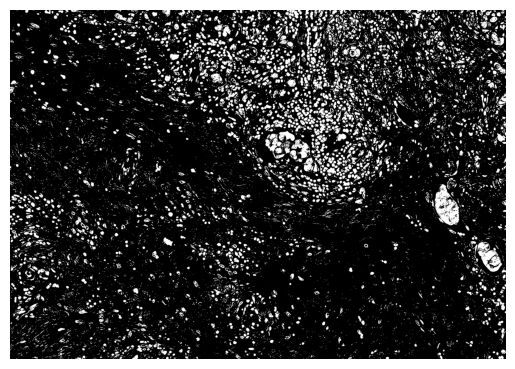

In [6]:
print(cluster_mask_dict)
plt.imshow(cluster_mask_dict['position_7_8tissue'], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()